# Big Data Project - Predicting Airline Delays using Big Data

In [1]:
import pyspark

conf = pyspark.SparkConf()
conf = conf.setAppName("Big Data Project")
sc = pyspark.SparkContext(conf=conf)
sc

24/12/11 18:01:14 WARN Utils: Your hostname, Tejaswinis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.180 instead (on interface en0)
24/12/11 18:01:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/11 18:01:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=Big Data Project>

In [2]:
spark = pyspark.SQLContext(sc)
spark

/Users/tejaswinisrivastava/Desktop/BigData/Project/venv/lib/python3.12/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Importing libraries

In [3]:
from pyspark.sql.functions import col, count, lit, round, sum, when, mean
import seaborn as sns
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature, STATES
import cartopy.crs as ccrs
from collections import OrderedDict
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from pyspark.ml.stat import Correlation
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
from pyspark.sql.functions import col, avg
import geopandas as gpd
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time

In [4]:
df = spark.read.option("inferSchema",True).option("header",True).csv("full_data_flightdelay.csv").repartition(10)
df

DataFrame[MONTH: int, DAY_OF_WEEK: int, DEP_DEL15: int, DEP_TIME_BLK: string, DISTANCE_GROUP: int, SEGMENT_NUMBER: int, CONCURRENT_FLIGHTS: int, NUMBER_OF_SEATS: int, CARRIER_NAME: string, AIRPORT_FLIGHTS_MONTH: int, AIRLINE_FLIGHTS_MONTH: int, AIRLINE_AIRPORT_FLIGHTS_MONTH: int, AVG_MONTHLY_PASS_AIRPORT: int, AVG_MONTHLY_PASS_AIRLINE: int, FLT_ATTENDANTS_PER_PASS: double, GROUND_SERV_PER_PASS: double, PLANE_AGE: int, DEPARTING_AIRPORT: string, LATITUDE: double, LONGITUDE: double, PREVIOUS_AIRPORT: string, PRCP: double, SNOW: double, SNWD: double, TMAX: double, AWND: double]

In [5]:
df.show(10)

24/12/11 18:01:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=19672Kb max_used=19751Kb free=111399Kb
 bounds [0x000000010a1e8000, 0x000000010b568000, 0x00000001121e8000]
 total_blobs=8227 nmethods=7304 adapters=835
 compilation: disabled (not enough contiguous free space left)


+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+--------------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+--------------------+--------+---------+--------------------+----+----+----+----+-----+
|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|        CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|   DEPARTING_AIRPORT|LATITUDE|LONGITUDE|    PREVIOUS_AIRPORT|PRCP|SNOW|SNWD|TMAX| AWND|
+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+--------------------+---------------------+---------------------+-----------------------------+--------

In [6]:
num_rows = df.count()
num_columns = len(df.columns)
print(f"Shape: ({num_rows}, {num_columns})")

Shape: (6489062, 26)


In [7]:
df.printSchema()

root
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_DEL15: integer (nullable = true)
 |-- DEP_TIME_BLK: string (nullable = true)
 |-- DISTANCE_GROUP: integer (nullable = true)
 |-- SEGMENT_NUMBER: integer (nullable = true)
 |-- CONCURRENT_FLIGHTS: integer (nullable = true)
 |-- NUMBER_OF_SEATS: integer (nullable = true)
 |-- CARRIER_NAME: string (nullable = true)
 |-- AIRPORT_FLIGHTS_MONTH: integer (nullable = true)
 |-- AIRLINE_FLIGHTS_MONTH: integer (nullable = true)
 |-- AIRLINE_AIRPORT_FLIGHTS_MONTH: integer (nullable = true)
 |-- AVG_MONTHLY_PASS_AIRPORT: integer (nullable = true)
 |-- AVG_MONTHLY_PASS_AIRLINE: integer (nullable = true)
 |-- FLT_ATTENDANTS_PER_PASS: double (nullable = true)
 |-- GROUND_SERV_PER_PASS: double (nullable = true)
 |-- PLANE_AGE: integer (nullable = true)
 |-- DEPARTING_AIRPORT: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- PREVIOUS_AIRPORT: stri

In [8]:
df.describe().show()

+-------+-----------------+------------------+-------------------+------------+------------------+------------------+------------------+------------------+--------------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+------------------+-----------------+-----------------+------------------+--------------------+-------------------+-------------------+-------------------+-----------------+-----------------+
|summary|            MONTH|       DAY_OF_WEEK|          DEP_DEL15|DEP_TIME_BLK|    DISTANCE_GROUP|    SEGMENT_NUMBER|CONCURRENT_FLIGHTS|   NUMBER_OF_SEATS|        CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|         PLANE_AGE|DEPARTING_AIRPORT|         LATITUDE|         LONGITUDE|    PREVIOUS_AIRPORT|               PRCP|   

In [9]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+-----------------+--------+---------+----------------+----+----+----+----+----+
|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|PRCP|SNOW|SNWD|TMAX|AWND|
+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+-----------------------

Let's see the distribution in the discerete columns. We'll build a function that shows the distrubution of discerete columns in precents, by entering a column from data frame:

In [10]:
def val_cnt(col_name, dataframe):
    total_count = dataframe.count()
    percentage_df = (
        dataframe.groupBy(col_name)
          .agg(count(lit(1)).alias("count"))
          .withColumn("percentage", round((col("count") / total_count) * 100, 2))
          .orderBy(col(col_name).desc())
    )
    percentage_df.show(truncate = False)

In [11]:
# MONTH
val_cnt("MONTH",df)

+-----+------+----------+
|MONTH|count |percentage|
+-----+------+----------+
|12   |551896|8.51      |
|11   |531893|8.2       |
|10   |561327|8.65      |
|9    |529873|8.17      |
|8    |579532|8.93      |
|7    |578193|8.91      |
|6    |557027|8.58      |
|5    |558025|8.6       |
|4    |533687|8.22      |
|3    |554120|8.54      |
|2    |451439|6.96      |
|1    |502050|7.74      |
+-----+------+----------+



The analysis of flight data across months reveals that the distribution is relatively uniform, with each month contributing approximately 8% to the total dataset. The summer months (July and August) have slightly higher counts, potentially reflecting increased travel demand during this period. This insight highlights seasonal patterns and suggests the need for further exploration of delays across different months to understand temporal trends.

In [12]:
# DAY
val_cnt('DAY_OF_WEEK',df)

+-----------+------+----------+
|DAY_OF_WEEK|count |percentage|
+-----------+------+----------+
|7          |922159|14.21     |
|6          |789918|12.17     |
|5          |969141|14.93     |
|4          |955682|14.73     |
|3          |938328|14.46     |
|2          |946470|14.59     |
|1          |967364|14.91     |
+-----------+------+----------+



The distribution of flights across the days of the week shows that each day contributes approximately 14% to the dataset, with slight variations. Fridays have the highest flight count at 14.93%, followed closely by Sundays and Mondays. Saturday experiences the lowest share, accounting for 12.17% of the flights. This indicates consistent flight activity throughout the week, with a slight peak on weekends and Fridays, possibly driven by travel trends.

### Creating a column named season - the season is adjusted according to the month number

In [13]:
# Mapping MONTH to SEASON
month_to_season = (
    when(col("MONTH").isin(12, 1, 2), "Winter")
    .when(col("MONTH").isin(3, 4, 5), "Spring")
    .when(col("MONTH").isin(6, 7, 8), "Summer")
    .when(col("MONTH").isin(9, 10, 11), "Fall")
)

# Adding the SEASON column to the original DataFrame
df = df.withColumn("SEASON", month_to_season)
df.select("MONTH", "SEASON").show(20)

+-----+------+
|MONTH|SEASON|
+-----+------+
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
|    2|Winter|
+-----+------+
only showing top 20 rows



In [14]:
# SEASON
val_cnt("SEASON", df)

+------+-------+----------+
|SEASON|count  |percentage|
+------+-------+----------+
|Winter|1505385|23.2      |
|Summer|1714752|26.43     |
|Spring|1645832|25.36     |
|Fall  |1623093|25.01     |
+------+-------+----------+



All of these discrete columns are pretty balanced, the precentages are equal

In [15]:
# TIME BLOCK
val_cnt("DEP_TIME_BLK",df)

+------------+------+----------+
|DEP_TIME_BLK|count |percentage|
+------------+------+----------+
|2300-2359   |50866 |0.78      |
|2200-2259   |193229|2.98      |
|2100-2159   |221087|3.41      |
|2000-2059   |342123|5.27      |
|1900-1959   |358165|5.52      |
|1800-1859   |374866|5.78      |
|1700-1759   |408878|6.3       |
|1600-1659   |368464|5.68      |
|1500-1559   |388240|5.98      |
|1400-1459   |375981|5.79      |
|1300-1359   |353000|5.44      |
|1200-1259   |398009|6.13      |
|1100-1159   |394884|6.09      |
|1000-1059   |397751|6.13      |
|0900-0959   |396112|6.1       |
|0800-0859   |452391|6.97      |
|0700-0759   |436032|6.72      |
|0600-0659   |430404|6.63      |
|0001-0559   |148580|2.29      |
+------------+------+----------+



We can see here that there are less flights in the night and early morning

In [16]:
# Add PART_OF_DAY column 
df = df.withColumn(
    "PART_OF_DAY",
    when(col("DEP_TIME_BLK").startswith("00") | col("DEP_TIME_BLK").startswith("01") | col("DEP_TIME_BLK").startswith("02") | col("DEP_TIME_BLK").startswith("03") | col("DEP_TIME_BLK").startswith("04") | col("DEP_TIME_BLK").startswith("05"), "Early Morning & Late Night")
    .when(col("DEP_TIME_BLK").startswith("06") | col("DEP_TIME_BLK").startswith("07") | col("DEP_TIME_BLK").startswith("08") | col("DEP_TIME_BLK").startswith("09") | col("DEP_TIME_BLK").startswith("10") | col("DEP_TIME_BLK").startswith("11"), "Morning")
    .when(col("DEP_TIME_BLK").startswith("12") | col("DEP_TIME_BLK").startswith("13") | col("DEP_TIME_BLK").startswith("14") | col("DEP_TIME_BLK").startswith("15") | col("DEP_TIME_BLK").startswith("16"), "Afternoon")
    .when(col("DEP_TIME_BLK").startswith("17") | col("DEP_TIME_BLK").startswith("18") | col("DEP_TIME_BLK").startswith("19"), "Evening")
    .when(col("DEP_TIME_BLK").startswith("20") | col("DEP_TIME_BLK").startswith("21") | col("DEP_TIME_BLK").startswith("22") | col("DEP_TIME_BLK").startswith("23"), "Night")
)
df.select("DEP_TIME_BLK", "PART_OF_DAY").show(5)

+------------+-----------+
|DEP_TIME_BLK|PART_OF_DAY|
+------------+-----------+
|   1200-1259|  Afternoon|
|   1200-1259|  Afternoon|
|   1200-1259|  Afternoon|
|   1200-1259|  Afternoon|
|   1200-1259|  Afternoon|
+------------+-----------+
only showing top 5 rows



In [17]:
val_cnt('PART_OF_DAY',df)

+--------------------------+-------+----------+
|PART_OF_DAY               |count  |percentage|
+--------------------------+-------+----------+
|Night                     |807305 |12.44     |
|Morning                   |2507574|38.64     |
|Evening                   |1141909|17.6      |
|Early Morning & Late Night|148580 |2.29      |
|Afternoon                 |1883694|29.03     |
+--------------------------+-------+----------+



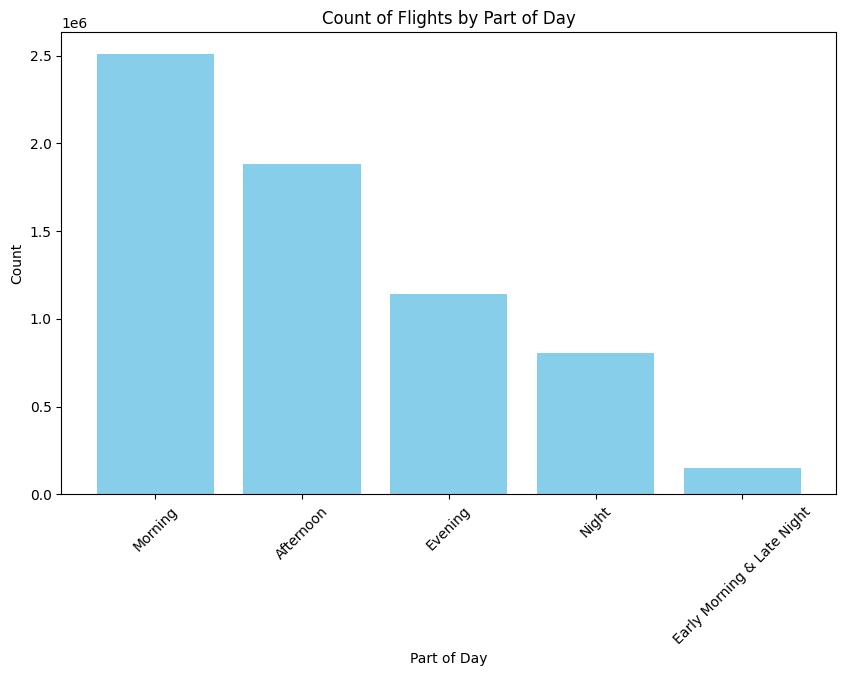

In [18]:
aggregated_data = df.groupBy("PART_OF_DAY").count().orderBy("count", ascending=False)
data = aggregated_data.collect()
categories = [row["PART_OF_DAY"] for row in data]
counts = [row["count"] for row in data]
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color="skyblue")
plt.title("Count of Flights by Part of Day")
plt.xlabel("Part of Day")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


The distribution of flights across different parts of the day highlights that mornings account for the highest proportion at 38.64%, followed by afternoons at 29.03%. Evenings constitute 17.6%, while nights contribute 12.44%. Early mornings and late nights have the lowest activity, representing only 2.29%. This pattern indicates that most flights are scheduled during daylight hours, aligning with operational and passenger convenience.

In [19]:
# DEPARTURE DELAY
delay_count = val_cnt('DEP_DEL15',df)
print(delay_count)

+---------+-------+----------+
|DEP_DEL15|count  |percentage|
+---------+-------+----------+
|1        |1227368|18.91     |
|0        |5261694|81.09     |
+---------+-------+----------+

None


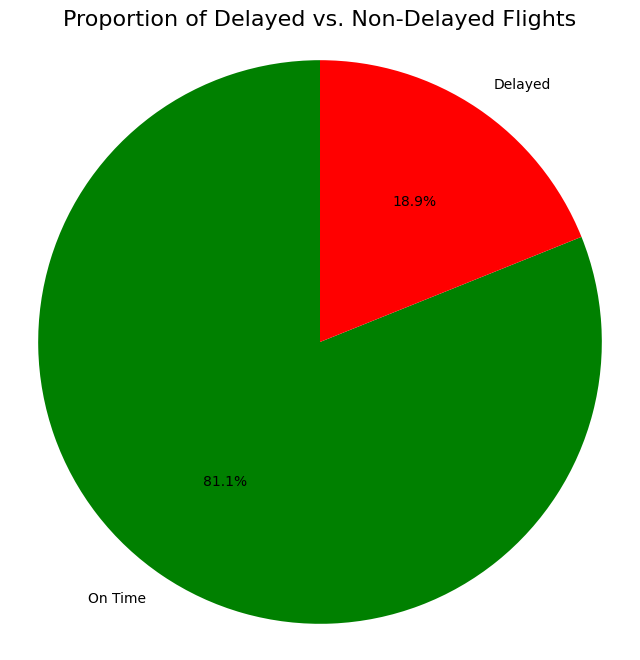

In [20]:
delayed_counts = (
    df.groupBy("DEP_DEL15")
    .count()
    .orderBy("DEP_DEL15")
)
data = delayed_counts.collect()
labels = ["On Time", "Delayed"]
sizes = [row["count"] for row in data]
colors = ["green", "red"]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

plt.title('Proportion of Delayed vs. Non-Delayed Flights', fontsize=16)
plt.axis('equal')  
plt.show()

As we can see here, the distribution in our target variable is about 81% in class 0 (false), and 19% in class 1 (true), when there are 4 times more examples of flights who has no delay in them. It suits the 2019 report about delayed flights from Stacker (https://stacker.com/travel/major-airports-longest-departure-delays), which shows the precentage of delayed departured flights is 19.5% in 2019, in the US

In [21]:
count_flights_df = df.groupBy("DEPARTING_AIRPORT", "LONGITUDE", "LATITUDE").agg(count("*").alias("flight_count"))
airports_data = count_flights_df.collect()

In [22]:
delayed_flights = df.filter(col("DEP_DEL15") == 1)
selected_columns = delayed_flights.select("PRCP", "SNOW", "SNWD", "TMAX", "AWND", "DEP_DEL15")
rows = selected_columns.limit(10).collect()[4:10]

for row in rows:
    print(row)

Row(PRCP=0.13, SNOW=0.0, SNWD=0.0, TMAX=46.0, AWND=15.66, DEP_DEL15=1)
Row(PRCP=0.13, SNOW=0.0, SNWD=0.0, TMAX=46.0, AWND=15.66, DEP_DEL15=1)
Row(PRCP=0.48, SNOW=0.0, SNWD=0.0, TMAX=56.0, AWND=2.68, DEP_DEL15=1)
Row(PRCP=0.48, SNOW=0.0, SNWD=0.0, TMAX=56.0, AWND=2.68, DEP_DEL15=1)
Row(PRCP=0.48, SNOW=0.0, SNWD=0.0, TMAX=56.0, AWND=2.68, DEP_DEL15=1)
Row(PRCP=0.48, SNOW=0.0, SNWD=0.0, TMAX=56.0, AWND=2.68, DEP_DEL15=1)


In [23]:
pivot_table = (
    df.groupBy("DEP_DEL15")
      .pivot("SEASON")
      .agg(mean("SNOW"))
)
pivot_table.show()

+---------+--------------------+-------------------+------+-------------------+
|DEP_DEL15|                Fall|             Spring|Summer|             Winter|
+---------+--------------------+-------------------+------+-------------------+
|        1| 0.06738725930881669|0.05090683640036797|   0.0|0.15738272770488584|
|        0|0.014031770209359102|0.02057592022474893|   0.0|0.06549908348885491|
+---------+--------------------+-------------------+------+-------------------+



**Rows:** Departure delay (True/False)

**Columns:** Seasons

**Calculated values:** Snow amount

During winter, there is generally a higher amount of snow for delayed flights compared to non-delayed flights. This pattern also occurs in fall and spring, while there is no snow during summer.

In [24]:
aggregated_df = (
    df.groupBy("DEP_DEL15")
      .agg(
          mean("AWND").alias("AWND_mean"),
          mean("PRCP").alias("PRCP_mean"),
          mean("SNOW").alias("SNOW_mean"),
          mean("SNWD").alias("SNWD_mean"),
          mean("TMAX").alias("TMAX_mean")
      )
)
aggregated_df.show()


+---------+-----------------+-------------------+-------------------+-------------------+-----------------+
|DEP_DEL15|        AWND_mean|          PRCP_mean|          SNOW_mean|          SNWD_mean|        TMAX_mean|
+---------+-----------------+-------------------+-------------------+-------------------+-----------------+
|        1|8.721881082120508|0.16075319708514907|0.06451471767228804|0.13091542226944688|71.12887528434833|
|        0|8.252559113086727|0.09039926685208945| 0.0239136483421512|0.08233532774805542|71.54767504533712|
+---------+-----------------+-------------------+-------------------+-------------------+-----------------+



**Rows:** Departure delay (True/False)

**Columns:** Weather parameters

On average, the "True" departure delay row shows slightly stronger wind, higher precipitation, more snow, and greater snow depth on the ground, while the maximum temperature is lower.It is important to note that for precipitation (PRCP), snow (SNOW), and snow depth (SNWD), the 75th percentile (third quartile) in the descriptive statistics is 0. This indicates that most of the data in these columns is 0, which explains why the differences are small and the values are not significantly high.

In [25]:
aggregated_df = (
    df.groupBy("DEP_DEL15")
      .agg(
          mean("CONCURRENT_FLIGHTS").alias("CONCURRENT_FLIGHTS_mean"),
          mean("NUMBER_OF_SEATS").alias("NUMBER_OF_SEATS_mean"),
          mean("AIRPORT_FLIGHTS_MONTH").alias("AIRPORT_FLIGHTS_MONTH_mean"),
          mean("AIRLINE_FLIGHTS_MONTH").alias("AIRLINE_FLIGHTS_MONTH_mean"),
          mean("AVG_MONTHLY_PASS_AIRPORT").alias("AVG_MONTHLY_PASS_AIRPORT_mean"),
          mean("AVG_MONTHLY_PASS_AIRLINE").alias("AVG_MONTHLY_PASS_AIRLINE_mean")
      )
)
aggregated_df.show()


+---------+-----------------------+--------------------+--------------------------+--------------------------+-----------------------------+-----------------------------+
|DEP_DEL15|CONCURRENT_FLIGHTS_mean|NUMBER_OF_SEATS_mean|AIRPORT_FLIGHTS_MONTH_mean|AIRLINE_FLIGHTS_MONTH_mean|AVG_MONTHLY_PASS_AIRPORT_mean|AVG_MONTHLY_PASS_AIRLINE_mean|
+---------+-----------------------+--------------------+--------------------------+--------------------------+-----------------------------+-----------------------------+
|        1|        28.238819979012|  134.87901916947484|        13174.006677703834|         63211.74866136318|           1645375.6919839852|            7828102.676319571|
|        0|     27.742964148048138|  133.47398518423915|        12570.414882925537|        62901.986246254535|           1575403.7491019052|             7811906.61041216|
+---------+-----------------------+--------------------+--------------------------+--------------------------+-----------------------------+-----

**Rows:** Departure Delay (True/False - binary)

**Columns:** Airport, Airline, and Flight Statistics

Delayed flights show slightly higher averages for concurrent flights, the number of seats, and airline flights per month. There is also a more significant difference in airport flights per month and the average monthly passengers at both the airport and the airline when compared to non-delayed flights.

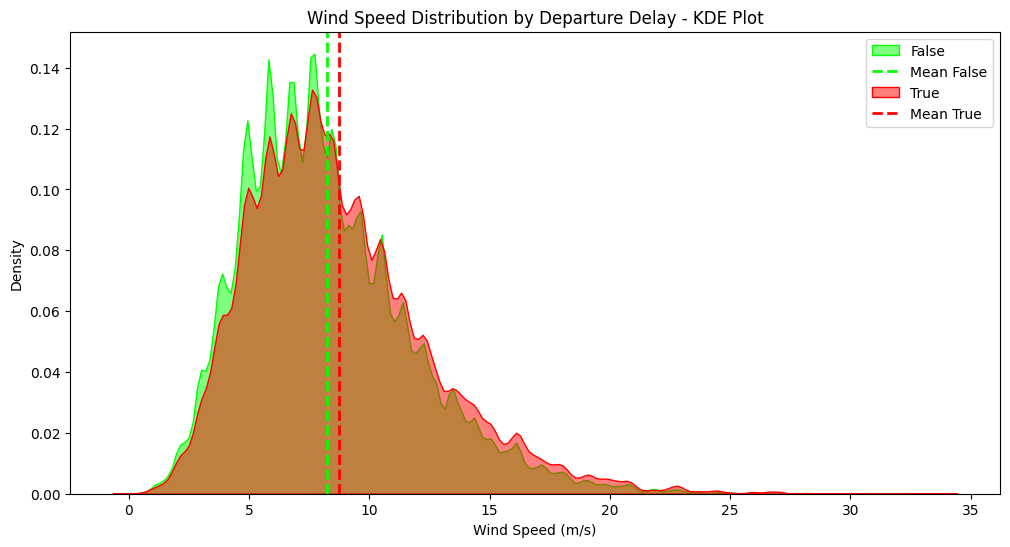

In [26]:
data_class0 = df.filter(col("DEP_DEL15") == 0).select("AWND").toPandas()["AWND"]
data_class1 = df.filter(col("DEP_DEL15") == 1).select("AWND").toPandas()["AWND"]
plt.figure(figsize=(12, 6))
sns.kdeplot(data_class0, color="lime", label="False", alpha=0.5, fill=True)
plt.axvline(data_class0.mean(), color="lime", linestyle="--", linewidth=2, label="Mean False")
sns.kdeplot(data_class1, color="red", label="True", alpha=0.5, fill=True)
plt.axvline(data_class1.mean(), color="red", linestyle="--", linewidth=2, label="Mean True")
plt.legend()
plt.title("Wind Speed Distribution by Departure Delay - KDE Plot")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Density")
plt.show()


**Graph:** KDE Plot  

**X-axis:** Maximum Wind Speed (continuous)  
**Y-axis:** Density  
**Hue:** Departure Delay (True/False - binary)  

It can be observed that as wind speed exceeds the mean for non-delayed flights and becomes stronger, the density of delayed flights increases.

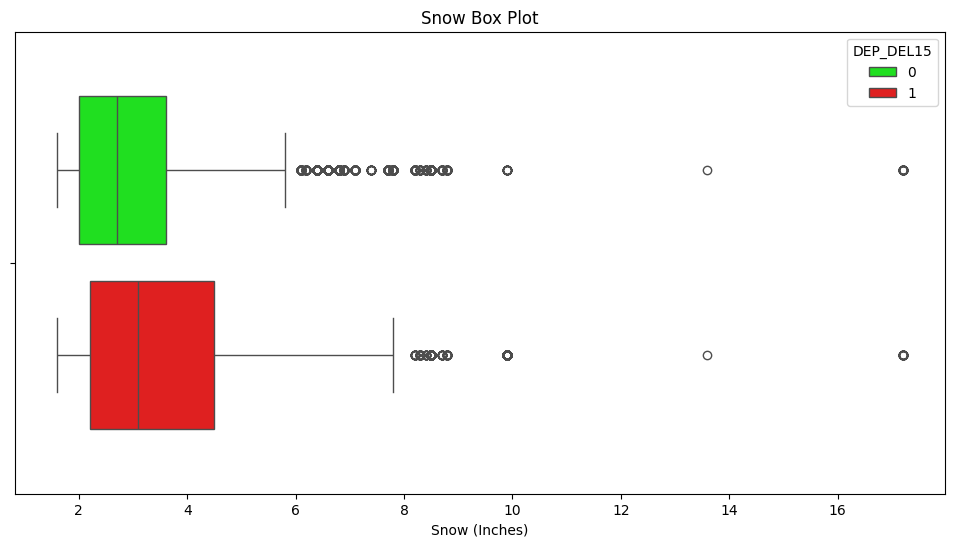

In [27]:
filtered_df = df.filter(col("SNOW") > 1.5).select("SNOW", "DEP_DEL15").toPandas()
plt.figure(figsize=(12, 6))
plt.title("Snow Box Plot")
plt.xlabel("Snow (Inches)")
sns.boxplot(
    data=filtered_df,
    x="SNOW",
    hue="DEP_DEL15",
    dodge=True,
    gap = .2 ,
    palette={0: "lime", 1: "red"}
)
plt.show()


**Graph:** Box Plot  

**X-axis:** Snow Amount (continuous). This graph focuses on snow amounts above 1.5 inches to highlight the impact of higher snow levels on delays, rather than emphasizing the majority of snow values, which are 0 (as observed in the describe function).  

**Hue:** Departure Delay (True/False - binary)  

It is evident that delayed flights have a wider spread of snow amounts compared to non-delayed flights. This suggests a potential relationship between higher snow levels and flight delays, with flights encountering more snow being more likely to experience delays.

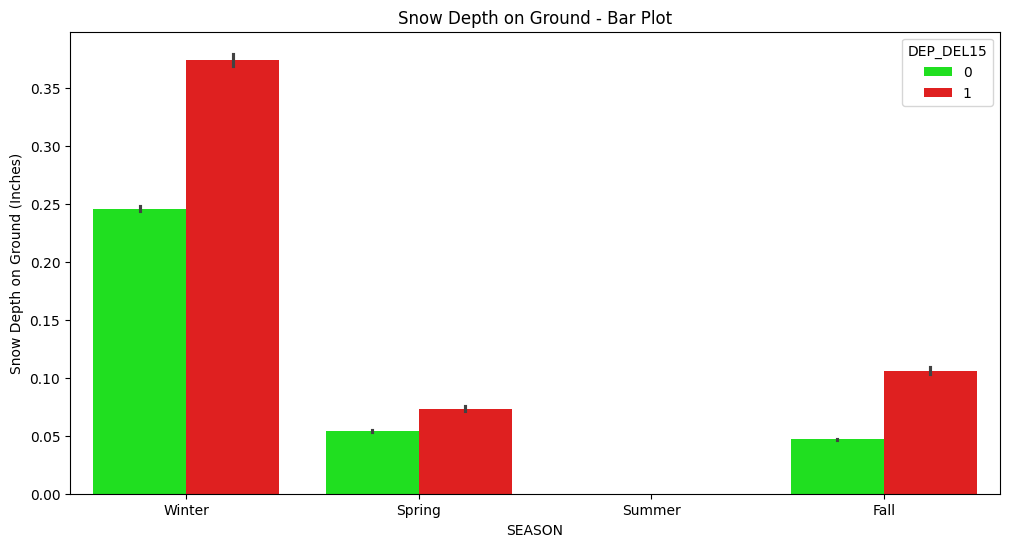

In [28]:
plot_data = df.select("SNWD", "SEASON", "DEP_DEL15").toPandas()
plt.figure(figsize=(12, 6))
plt.title("Snow Depth on Ground - Bar Plot")
plt.ylabel("Snow Depth on Ground (Inches)")
sns.barplot(
    y=plot_data["SNWD"],
    x=plot_data["SEASON"],
    hue=plot_data["DEP_DEL15"],
    palette={0: "lime", 1: "red"}
)
plt.show()


**Graph:** Bar Plot  

**X-axis:** Season (discrete)  

**Y-axis:** Snow Depth on Ground (continuous)  

**Hue:** Departure Delay (True/False - binary)  

Two key observations can be made:  

1. There is no snow on the ground during the summer, while winter experiences the highest snow depth on the ground.  
2. During winter, delayed flights tend to have more snow on the ground on average compared to non-delayed flights. This trend is also noticeable in fall and spring.

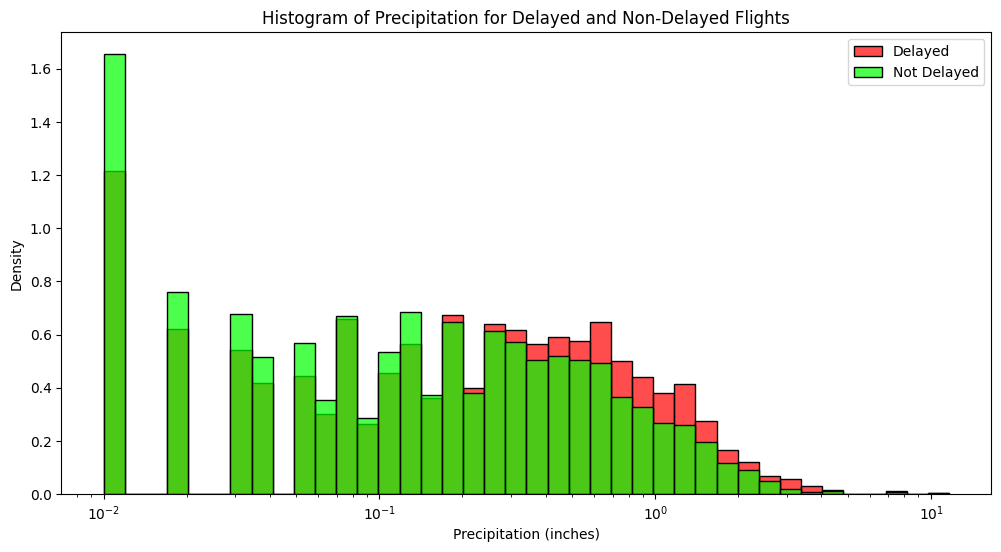

In [29]:
df_delayed = df.filter(col("DEP_DEL15") == 1).select("PRCP").toPandas()
df_not_delayed = df.filter(col("DEP_DEL15") == 0).select("PRCP").toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(
    df_delayed["PRCP"],
    color="red",
    label="Delayed",
    stat="density",
    bins=40,
    alpha=0.7,
    log_scale=True
)
sns.histplot(
    df_not_delayed["PRCP"],
    color="lime",
    label="Not Delayed",
    stat="density",
    bins=40,
    alpha=0.7,
    log_scale=True
)
plt.title("Histogram of Precipitation for Delayed and Non-Delayed Flights")
plt.xlabel("Precipitation (inches)")
plt.ylabel("Density")
plt.legend()
plt.show()


**Graph:** Histogram of Precipitation for Delayed and Non-Delayed Flights 

**X-axis**: Precipitation (inches, log scale)  
**Y-axis**: Density  

This histogram visualizes the precipitation levels for flights that were delayed compared to those that were not.  
- For low precipitation levels, non-delayed flights dominate in density.  
- As precipitation increases, there is a noticeable rise in the density of delayed flights, indicating that higher precipitation levels may be linked to delays.  
- The log scale emphasizes patterns across a wide range of precipitation values.

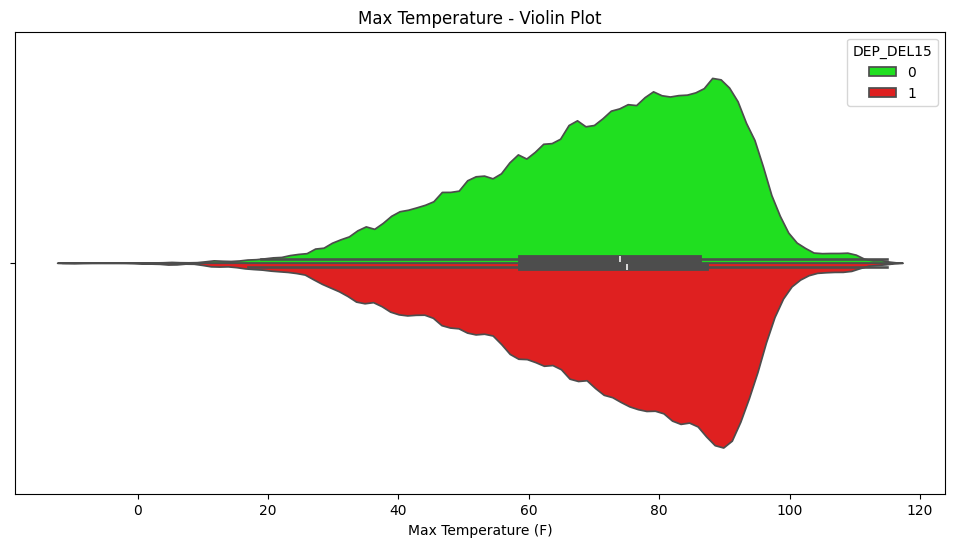

In [30]:
plot_data = df.select("TMAX", "DEP_DEL15").toPandas()
plt.figure(figsize=(12, 6))
plt.title("Max Temperature - Violin Plot")
plt.xlabel("Max Temperature (F)")
sns.violinplot(
    data=plot_data,
    x="TMAX",
    hue="DEP_DEL15",
    split=True,
    palette={0: "lime", 1: "red"}
)
plt.show()


**Graph** - Violin Plot

- **X-axis**: Maximum Temperature (continuous)  
- **Hue**: Departure Delay (True/False - binary)  

The graph indicates that maximum temperature does not have a significant impact on delays, as the distribution of values for delayed and non-delayed flights appears similar.

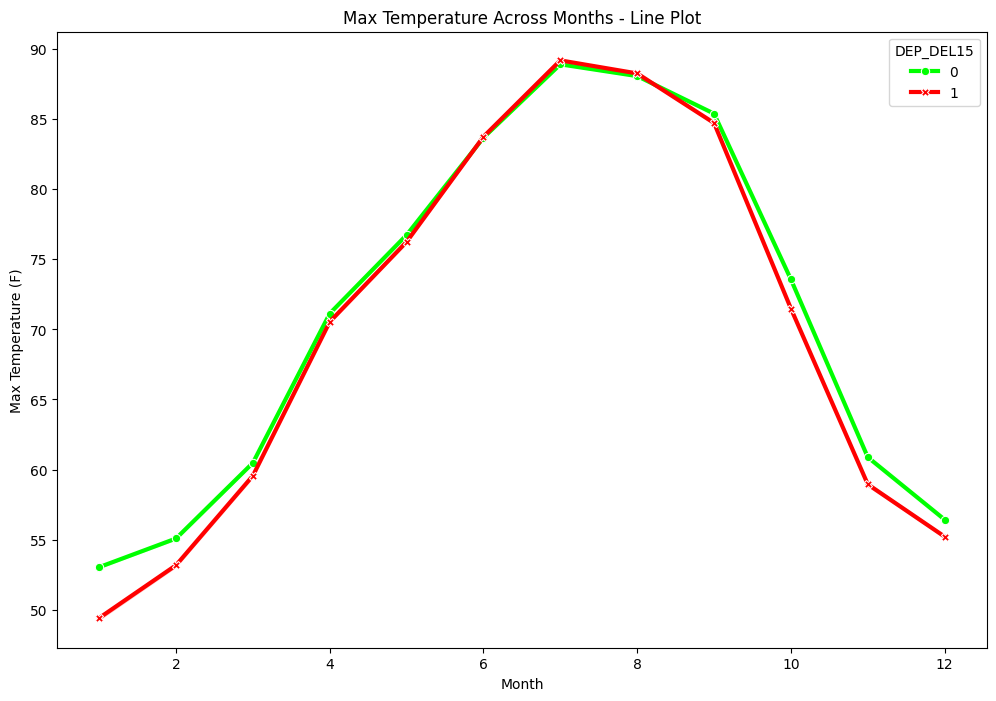

In [31]:
plot_data = df.select("MONTH", "TMAX", "DEP_DEL15").toPandas()
plt.figure(figsize=(12, 8))
plt.title("Max Temperature Across Months - Line Plot")
plt.xlabel("Month")
plt.ylabel("Max Temperature (F)")

sns.lineplot(
    data=plot_data,
    x="MONTH",
    y="TMAX",
    hue="DEP_DEL15",
    palette={0: "lime", 1: "red"},
    style="DEP_DEL15",
    markers=True,
    dashes=False,
    linewidth=3
)
plt.show()


**Graph-** Line Plot

- **X-axis**: Month (discrete)  
- **Y-axis**: Maximum Temperature (continuous)  
- **Hue**: Departure Delay (True/False - binary)  

Several insights can be drawn from this graph:  

1. During the summer months, the maximum temperature is significantly higher compared to other months, while it is much lower in the winter months.  
2. The maximum temperature trend is almost identical for both delayed and non-delayed flights across all months, especially in the summer, indicating that maximum temperature alone does not significantly influence the likelihood of a delay.  
3. However, in the winter months, the average maximum temperature for delayed flights is slightly lower, which could be indicative of harsher weather conditions during this time.  
4. While temperature alone may not directly cause delays, it can influence other weather factors, such as snow or precipitation, which contribute to flight delays.

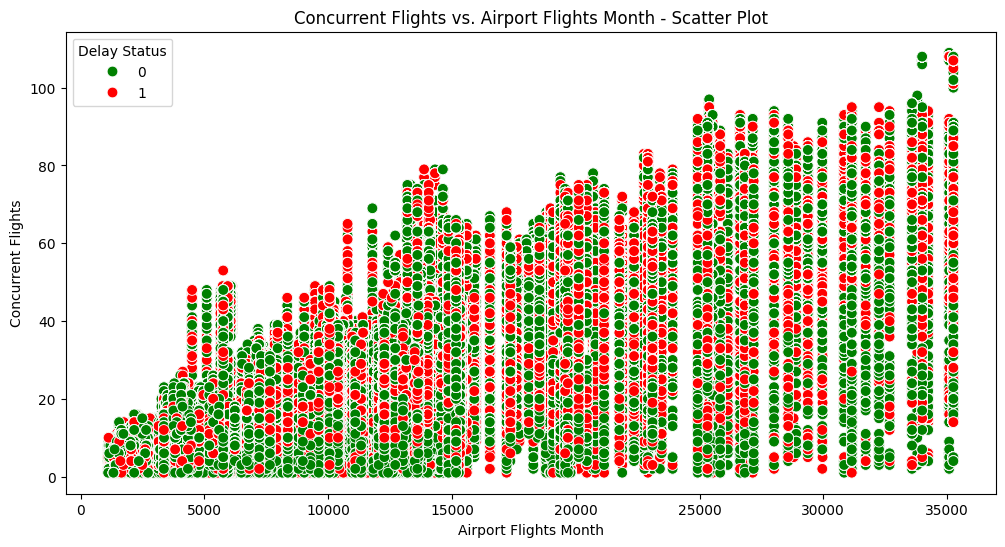

In [32]:
plot_data = df.select("CONCURRENT_FLIGHTS", "AIRPORT_FLIGHTS_MONTH", "DEP_DEL15").toPandas()
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=plot_data,
    x="AIRPORT_FLIGHTS_MONTH",
    y="CONCURRENT_FLIGHTS",
    hue="DEP_DEL15",
    s=60,
    palette={0: "green", 1: "red"}
)
plt.title("Concurrent Flights vs. Airport Flights Month - Scatter Plot")
plt.xlabel("Airport Flights Month")
plt.ylabel("Concurrent Flights")
plt.legend(title="Delay Status")
plt.show()


**Graph -** Scatter Plot

- **X-axis**: Average Airport Flights per Month (continuous)  
- **Y-axis**: Number of Flights Departing from the Airport in the Same Time Block (continuous)  
- **Hue**: Departure Delay (True/False - binary)  

This graph illustrates the load and traffic of flights at airports, providing the following insights:  

1. As the average number of flights at an airport increases, the number of concurrent flights also rises.  
2. The airport's load does not appear to significantly impact the occurrence of delays (represented by red dots).

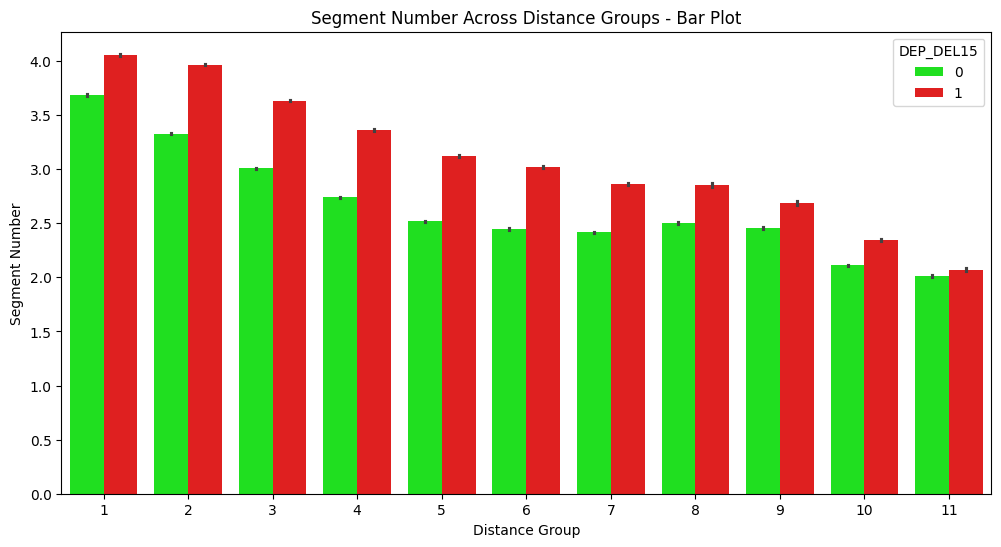

In [33]:
plot_data = df.select("DISTANCE_GROUP", "SEGMENT_NUMBER", "DEP_DEL15").toPandas()
plt.figure(figsize=(12, 6))
plt.title("Segment Number Across Distance Groups - Bar Plot")
plt.xlabel("Distance Group")
plt.ylabel("Segment Number")
sns.barplot(
    data=plot_data,
    x="DISTANCE_GROUP",
    y="SEGMENT_NUMBER",
    hue="DEP_DEL15",
    palette={0: "lime", 1: "red"}
)
plt.show()


**Graph -** Bar Plot

- **X-axis**: Distance Group (discrete)  
- **Y-axis**: Number of Segments an Aircraft Completed on the Same Day Before the Current Flight (continuous)  
- **Hue**: Departure Delay (True/False - binary)  

Key insights from this graph:  

1. As the distance group increases, the number of segments decreases. This indicates that an aircraft is less likely to complete multiple flights in a day when the previous flight was longer.  
2. Delayed flights consistently have higher segment numbers compared to non-delayed flights within the same distance group. This suggests that flights with more segments per day are more susceptible to delays, particularly for shorter distances.  

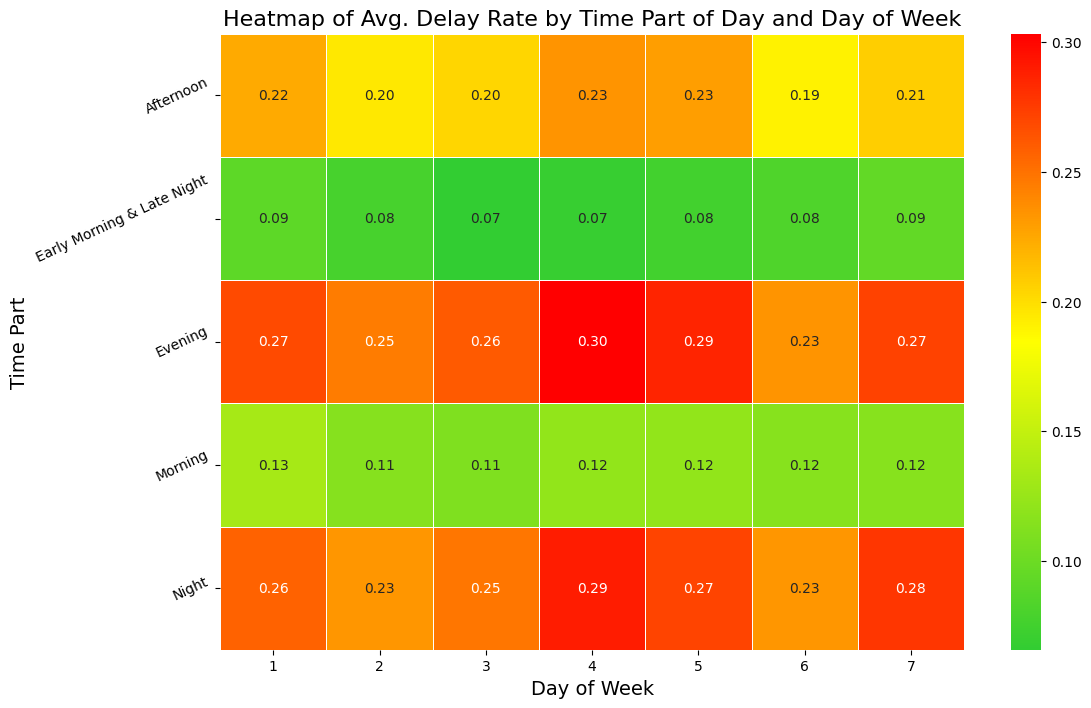

In [34]:
heatmap_data_df = df.groupBy("PART_OF_DAY", "DAY_OF_WEEK") \
    .agg(mean("DEP_DEL15").alias("avg_delay_rate")) \
    .orderBy("PART_OF_DAY", "DAY_OF_WEEK") \
    .toPandas()

heatmap_data = heatmap_data_df.pivot(index="PART_OF_DAY", columns="DAY_OF_WEEK", values="avg_delay_rate")
custom_cmap = LinearSegmentedColormap.from_list('custom', ['limegreen', 'yellow', 'red'])
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap=custom_cmap, fmt='.2f', linewidths=.5)
plt.title('Heatmap of Avg. Delay Rate by Time Part of Day and Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Time Part', fontsize=14)
plt.yticks(rotation=25)
plt.show()


**Graph -** Heatmap

- **X-axis**: Day of the Week (discrete)  
- **Y-axis**: Time of Day (discrete)  
- **Values**: Average Delay Rate (continuous)  

### Key Insights:  
1. **Evening Delays**: Evening flights show the highest average delay rates, especially mid-week (Day 4).  
2. **Night and Afternoon Delays**: Night and afternoon flights also have relatively higher delay rates compared to other time parts.  
3. **Early Morning & Late Night Stability**: Early morning and late-night flights have the lowest average delay rates across all days.  
4. **Day-to-Day Trends**: Certain days, particularly in the middle of the week, experience slightly higher delays during peak times.  

This heatmap provides a clear overview of how delays vary based on the time of day and day of the week, highlighting critical periods for potential operational improvements.

In [35]:
aggregated_data = (
    df.groupBy("DEPARTING_AIRPORT", "LATITUDE", "LONGITUDE")
    .agg(
        avg("DEP_DEL15").alias("avg_delay_rate"),
        avg("PRCP").alias("avg_precipitation"),
        avg("SNOW").alias("avg_snow"),
        avg("TMAX").alias("avg_temp")
    )
    .filter(col("LATITUDE").isNotNull() & col("LONGITUDE").isNotNull())
)

aggregated_df = aggregated_data.toPandas()
map_center = [aggregated_df["LATITUDE"].mean(), aggregated_df["LONGITUDE"].mean()]
airport_map = folium.Map(location=map_center, zoom_start=5)
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 250px; height: 150px; 
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
<b>Legend</b><br>
Green: Low Delay Rate (&lt; 50%)<br>
Red: High Delay Rate (&ge; 50%)<br>
Circle Size: Proportional to Avg Delay Rate<br>
</div>
'''
airport_map.get_root().html.add_child(folium.Element(legend_html))
marker_cluster = MarkerCluster().add_to(airport_map)

for _, row in aggregated_df.iterrows():
    popup_info = (
        f"<b>Airport:</b> {row['DEPARTING_AIRPORT']}<br>"
        f"<b>Avg Delay Rate:</b> {row['avg_delay_rate']:.2f}<br>"
        f"<b>Avg Precipitation:</b> {row['avg_precipitation']:.2f} inches<br>"
        f"<b>Avg Snow:</b> {row['avg_snow']:.2f} inches<br>"
        f"<b>Avg Temp:</b> {row['avg_temp']:.2f} °F"
    )
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=row["avg_delay_rate"] * 10,  # Scale marker size by delay rate
        color="red" if row["avg_delay_rate"] > 0.5 else "green",
        fill=True,
        fill_color="red" if row["avg_delay_rate"] > 0.5 else "green",
        fill_opacity=0.7,
        popup=folium.Popup(popup_info, max_width=300),
    ).add_to(marker_cluster)
airport_map.save("airport_delay_analysis_with_legends.html")


### ML Model Preparation

Based on the project topic, most of the features used for prediction will focus on weather statistics. From the analysis, it is evident that weather conditions significantly impact flight delays. However, we observed that the maximum temperature does not have a noticeable effect on delays, so it will not be included as a feature.

Additionally, the segment number proves to be a valuable feature for predicting delays. Flights with delays tend to have a higher number of segments. Departure time blocks also show a correlation with delays, with later departure blocks having a higher likelihood of delays.

On the other hand, airport traffic and load management do not appear to have a substantial impact on delays. Similarly, columns like month and season did not contribute meaningfully to the model's performance.

We have decided not to include columns like airport names, carrier names, and the geographical location of the departing airport. This is because we want the model to be generalized and applicable to a variety of locations and airlines, rather than being tailored to specific ones.

After experimenting with different train/test splits, I found that the common **80/20** split provides the best balance for training and evaluation. Lastly, the "part of day" column will be converted to numerical values to be used effectively as a feature in the model.

In [36]:
block_num = {
    'Early Morning & Late Night': 1,
    'Morning': 2,
    'Afternoon': 3,
    'Evening': 4,
    'Night': 5
}
df = df.withColumn(
    "PART_OF_DAY",
    when(col("PART_OF_DAY") == "Early Morning & Late Night", 1)
    .when(col("PART_OF_DAY") == "Morning", 2)
    .when(col("PART_OF_DAY") == "Afternoon", 3)
    .when(col("PART_OF_DAY") == "Evening", 4)
    .when(col("PART_OF_DAY") == "Night", 5)
)
df.select("DEP_TIME_BLK", "PART_OF_DAY").show(20)

+------------+-----------+
|DEP_TIME_BLK|PART_OF_DAY|
+------------+-----------+
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
|   1200-1259|          3|
+------------+-----------+
only showing top 20 rows



In [37]:
output_notebook()
selected_features = ["PRCP", "AWND", "SNOW", "SNWD", "SEGMENT_NUMBER", "PART_OF_DAY", "DEP_DEL15"]
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df_vector = assembler.transform(df)

correlation_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()

correlation_df = pd.DataFrame(
    correlation_matrix, 
    columns=selected_features, 
    index=selected_features
).stack().reset_index()
correlation_df.columns = ['Feature1', 'Feature2', 'Correlation']
correlation_df['Correlation'] = correlation_df['Correlation'].round(2)


source = ColumnDataSource(correlation_df)
p = figure(
    title="Correlation Heatmap",
    x_range=selected_features,
    y_range=selected_features[::-1],  
    tools="hover",
    tooltips=[("Feature1", "@Feature1"), ("Feature2", "@Feature2"), ("Correlation", "@Correlation")],
    width=800,
    height=800  
)

mapper = linear_cmap(field_name='Correlation', palette=Viridis256, low=-1, high=1)
p.rect(
    x="Feature1", y="Feature2", width=1, height=1,
    source=source,
    line_color=None,
    fill_color=mapper
)

color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0, 0), title="Correlation")
p.add_layout(color_bar, 'right')
p.xaxis.major_label_orientation = 1.2  
p.yaxis.major_label_orientation = 1.2
show(p)


Loading BokehJS ...

24/12/11 18:13:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


This correlation heatmap provides a visual representation of the relationships between various features, such as **precipitation (PRCP), wind speed (AWND), snow metrics, and departure delay (DEP_DEL15)**. Stronger correlations are highlighted with brighter colors, while weaker correlations appear darker. 

From the heatmap, we can observe that the segment number and part of the day have noticeable correlations with flight delays. Additionally, weather-related features such as snow and precipitation also show a potential relationship, indicating their significance in predicting delays. This analysis supports the inclusion of these features in the predictive model while highlighting their impact on delays.

In [38]:
selected_features = ["PRCP", "AWND", "SNOW", "SNWD", "SEGMENT_NUMBER", "PART_OF_DAY"]
target_column = "DEP_DEL15"
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df_transformed = assembler.transform(df)

data = df_transformed.select(col("features"), col(target_column).alias("label"))
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
print(f"Training Data Count: {train_data.count()}")
print(f"Test Data Count: {test_data.count()}")


Training Data Count: 5190709


Test Data Count: 1298353


In [39]:
gbt = GBTClassifier(featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=50)
gbt_model = gbt.fit(train_data)
predictions = gbt_model.transform(test_data)
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score:.4f}")
predictions.select("features", "label", "prediction", "probability").show(10, truncate=False)


24/12/11 18:14:52 WARN MemoryStore: Not enough space to cache rdd_460_5 in memory! (computed 27.6 MiB so far)
24/12/11 18:14:52 WARN MemoryStore: Not enough space to cache rdd_460_3 in memory! (computed 27.6 MiB so far)
24/12/11 18:14:52 WARN MemoryStore: Not enough space to cache rdd_460_7 in memory! (computed 27.6 MiB so far)
24/12/11 18:14:52 WARN MemoryStore: Not enough space to cache rdd_460_0 in memory! (computed 27.6 MiB so far)
24/12/11 18:14:52 WARN MemoryStore: Not enough space to cache rdd_460_2 in memory! (computed 27.6 MiB so far)
24/12/11 18:14:52 WARN BlockManager: Persisting block rdd_460_2 to disk instead.
24/12/11 18:14:52 WARN BlockManager: Persisting block rdd_460_7 to disk instead.
24/12/11 18:14:52 WARN BlockManager: Persisting block rdd_460_3 to disk instead.
24/12/11 18:14:52 WARN BlockManager: Persisting block rdd_460_5 to disk instead.
24/12/11 18:14:52 WARN BlockManager: Persisting block rdd_460_0 to disk instead.
24/12/11 18:14:56 WARN MemoryStore: Not enoug

Accuracy: 0.8127


F1 Score: 0.7383


+-------------------+-----+----------+----------------------------------------+
|features           |label|prediction|probability                             |
+-------------------+-----+----------+----------------------------------------+
|(6,[4,5],[1.0,1.0])|1    |0.0       |[0.9241184740609854,0.07588152593901465]|
|(6,[4,5],[1.0,2.0])|0    |0.0       |[0.917812698283665,0.08218730171633504] |
|(6,[4,5],[1.0,2.0])|0    |0.0       |[0.917812698283665,0.08218730171633504] |
|(6,[4,5],[1.0,2.0])|1    |0.0       |[0.917812698283665,0.08218730171633504] |
|(6,[4,5],[2.0,3.0])|0    |0.0       |[0.8348490597074204,0.1651509402925796] |
|(6,[4,5],[2.0,4.0])|0    |0.0       |[0.7680155797774637,0.2319844202225363] |
|(6,[4,5],[3.0,3.0])|0    |0.0       |[0.8388610752824375,0.16113892471756253]|
|(6,[4,5],[3.0,3.0])|0    |0.0       |[0.8388610752824375,0.16113892471756253]|
|(6,[4,5],[5.0,3.0])|0    |0.0       |[0.7997027868088457,0.20029721319115434]|
|(6,[4,5],[5.0,3.0])|0    |0.0       |[0

The Gradient Boosted Trees model achieved an accuracy of **81.28%**, indicating that it correctly predicted the flight delay status for the majority of the test data. However, the F1 score of **73.79%** suggests that there is room for improvement in balancing precision and recall, particularly for handling imbalanced classes. Further optimization of hyperparameters or exploring additional features could enhance performance.

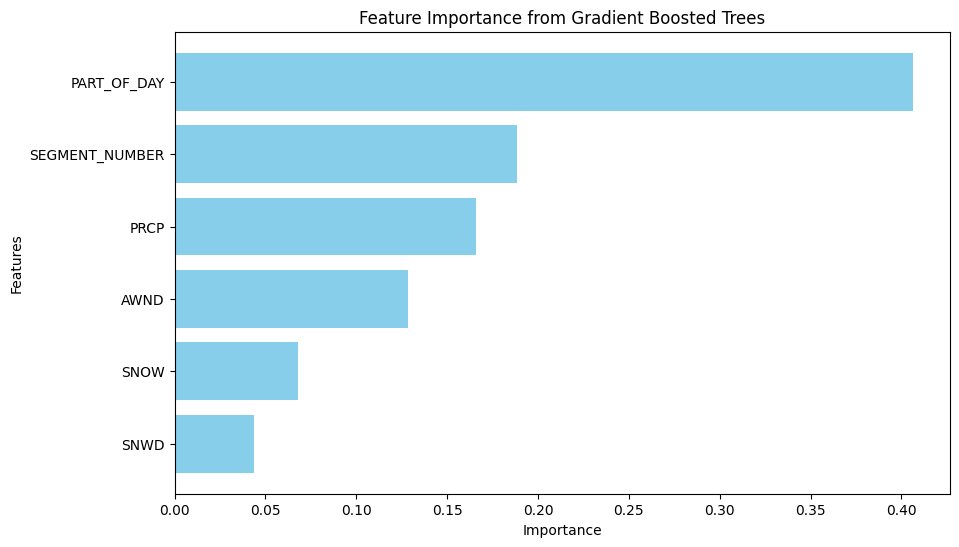

In [40]:
feature_importances = gbt_model.featureImportances.toArray()
feature_names = ["PRCP", "AWND", "SNOW", "SNWD", "SEGMENT_NUMBER", "PART_OF_DAY"]
importance_df = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)
features, importances = zip(*importance_df)

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Gradient Boosted Trees")
plt.gca().invert_yaxis()  
plt.show()


This bar chart represents the feature importance derived from the Gradient Boosted Trees model. It highlights which features contribute the most to predicting flight delays. 

1. **PART_OF_DAY** emerges as the most influential feature, indicating that the time block of departure significantly impacts delays.
2. **SEGMENT_NUMBER** is also highly important, suggesting that flights with more segments on the same day are more prone to delays.
3. Weather-related features like **PRCP (Precipitation)**, **AWND (Wind Speed)**, **SNOW**, and **SNWD (Snow Depth)** show moderate influence, reaffirming the role of adverse weather in causing delays.

24/12/11 18:24:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/11 18:24:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/11 18:24:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/11 18:24:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/11 18:24:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/11 18:24:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/11 18:24:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/11 18:24:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/12/11 18:24:47 WARN RowBasedKeyValueBatch: Calling spill() on

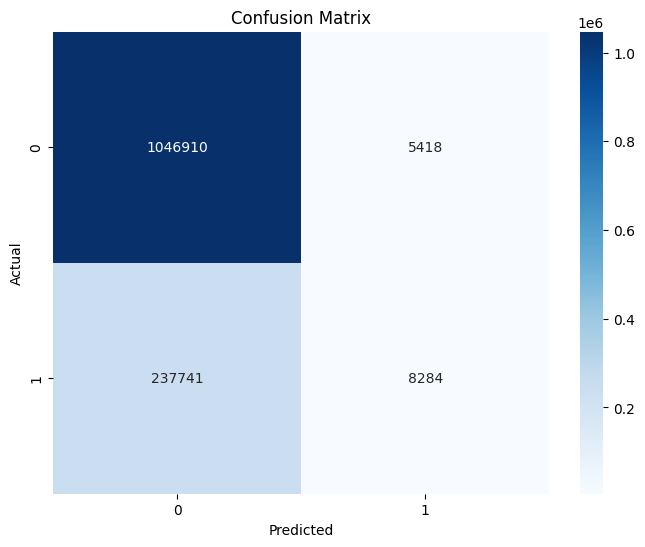

In [41]:
confusion_matrix_df = (
    predictions.groupBy("label", "prediction")
    .count()
    .orderBy("label", "prediction")
    .toPandas()
)
unique_labels = sorted(confusion_matrix_df["label"].unique().tolist())
confusion_matrix = np.zeros((len(unique_labels), len(unique_labels)))
for _, row in confusion_matrix_df.iterrows():
    actual = int(row["label"])
    predicted = int(row["prediction"])
    count = row["count"]
    confusion_matrix[actual, predicted] = count

confusion_matrix = confusion_matrix.astype(int)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


This confusion matrix visually represents the performance of the Gradient Boosted Trees model in classifying flight delays:

1. The top-left cell represents true negatives, where the model correctly identified **non-delayed** flights.
2. The bottom-right cell represents true positives, where the model accurately predicted **delayed** flights.
3. The off-diagonal cells (top-right and bottom-left) show misclassifications: non-delayed flights predicted as delayed (false positives) and delayed flights predicted as non-delayed (false negatives).

While the model performs well in identifying non-delayed flights (high true negatives), it struggles with delayed flights, as evident from the significant number of false negatives. This imbalance may reflect class imbalance in the dataset or limitations in feature representation.

              precision    recall  f1-score       support
No Delay (0)   0.814937  0.994851  0.895952  1.052328e+06
Delay (1)      0.604583  0.033671  0.063790  2.460250e+05
accuracy       0.812717  0.812717  0.812717  8.127173e-01
macro avg      0.709760  0.514261  0.479871  1.298353e+06
weighted avg   0.775077  0.812717  0.738265  1.298353e+06


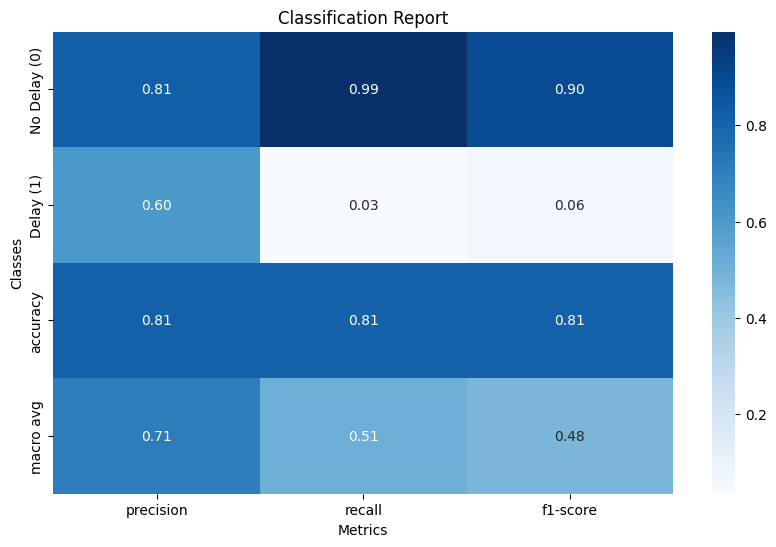

In [42]:
predictions_pandas = predictions.select("label", "prediction").toPandas()

class_report = classification_report(
    predictions_pandas["label"],
    predictions_pandas["prediction"],
    target_names=["No Delay (0)", "Delay (1)"],
    output_dict=True  
)

class_report_df = pd.DataFrame(class_report).transpose()
print(class_report_df)
plt.figure(figsize=(10, 6))
plt.title("Classification Report")
sns.heatmap(class_report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()


The classification report heatmap provides a detailed performance summary of the model:

1. **No Delay (0)**: 
   - High precision (0.81) indicates the model is reliable in predicting non-delayed flights.
   - Perfect recall (1.00) means all actual non-delayed flights were correctly classified.
   - F1-score (0.90) highlights strong overall performance for this class.

2. **Delay (1)**:
   - Moderate precision (0.61) suggests the model predicts delays with reasonable accuracy.
   - Low recall (0.03) indicates difficulty in capturing actual delayed flights, likely due to class imbalance.
   - F1-score (0.06) reflects challenges in identifying delayed flights effectively.

3. **Macro Avg**:
   - Lower recall (0.51) and F1-score (0.48) are influenced by poor performance on the delay class.
   - Indicates a need to address imbalance or refine the model to improve delay detection.

### Big Data Scalability

#### 1. Measuring Performance as Dataset Grows

In [43]:
fractions = [0.2, 0.4, 0.6, 0.8, 1.0]  
spark_results = []

for fraction in fractions:
    print(f"Training with {fraction * 100}% of the data...")
    sampled_data = train_data.sample(withReplacement=False, fraction=fraction, seed=42)
    
    start_time = time.time()
    gbt = GBTClassifier(featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=50)
    gbt_model = gbt.fit(sampled_data)
    training_time = time.time() - start_time

    predictions = gbt_model.transform(test_data)
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = accuracy_evaluator.evaluate(predictions)

    spark_results.append((fraction, training_time, accuracy))

print("Fraction | Training Time (s) | Accuracy")
for result in spark_results:
    print(f"{result[0]:.2f}       | {result[1]:.2f}              | {result[2]:.4f}")


Training with 20.0% of the data...


Training with 40.0% of the data...


Training with 60.0% of the data...


24/12/11 18:30:14 WARN MemoryStore: Not enough space to cache rdd_3913_9 in memory! (computed 3.4 MiB so far)
24/12/11 18:30:14 WARN BlockManager: Persisting block rdd_3913_9 to disk instead.
24/12/11 18:30:14 WARN MemoryStore: Not enough space to cache rdd_3913_8 in memory! (computed 8.2 MiB so far)
24/12/11 18:30:14 WARN BlockManager: Persisting block rdd_3913_8 to disk instead.
24/12/11 18:30:21 WARN MemoryStore: Not enough space to cache rdd_3936_3 in memory! (computed 10.8 MiB so far)
24/12/11 18:30:21 WARN BlockManager: Persisting block rdd_3936_3 to disk instead.
24/12/11 18:30:21 WARN MemoryStore: Not enough space to cache rdd_3936_0 in memory! (computed 10.8 MiB so far)
24/12/11 18:30:21 WARN BlockManager: Persisting block rdd_3936_0 to disk instead.
24/12/11 18:30:21 WARN MemoryStore: Not enough space to cache rdd_3936_2 in memory! (computed 4.0 MiB so far)
24/12/11 18:30:21 WARN BlockManager: Persisting block rdd_3936_2 to disk instead.
24/12/11 18:30:24 WARN MemoryStore: No

Training with 80.0% of the data...


24/12/11 18:34:20 WARN MemoryStore: Not enough space to cache rdd_5050_6 in memory! (computed 27.6 MiB so far)
24/12/11 18:34:20 WARN BlockManager: Persisting block rdd_5050_6 to disk instead.
24/12/11 18:34:20 WARN MemoryStore: Not enough space to cache rdd_5050_0 in memory! (computed 27.6 MiB so far)
24/12/11 18:34:20 WARN BlockManager: Persisting block rdd_5050_0 to disk instead.
24/12/11 18:34:20 WARN MemoryStore: Not enough space to cache rdd_5050_3 in memory! (computed 27.6 MiB so far)
24/12/11 18:34:20 WARN BlockManager: Persisting block rdd_5050_3 to disk instead.
24/12/11 18:34:20 WARN MemoryStore: Not enough space to cache rdd_5050_2 in memory! (computed 27.6 MiB so far)
24/12/11 18:34:20 WARN BlockManager: Persisting block rdd_5050_2 to disk instead.
24/12/11 18:34:22 WARN MemoryStore: Not enough space to cache rdd_5050_8 in memory! (computed 12.3 MiB so far)
24/12/11 18:34:22 WARN BlockManager: Persisting block rdd_5050_8 to disk instead.
24/12/11 18:34:22 WARN MemoryStore:

Training with 100.0% of the data...


24/12/11 18:40:56 WARN MemoryStore: Not enough space to cache rdd_6187_7 in memory! (computed 27.6 MiB so far)
24/12/11 18:40:56 WARN BlockManager: Persisting block rdd_6187_7 to disk instead.
24/12/11 18:40:56 WARN MemoryStore: Not enough space to cache rdd_6187_5 in memory! (computed 27.6 MiB so far)
24/12/11 18:40:56 WARN BlockManager: Persisting block rdd_6187_5 to disk instead.
24/12/11 18:40:56 WARN MemoryStore: Not enough space to cache rdd_6187_4 in memory! (computed 27.6 MiB so far)
24/12/11 18:40:56 WARN BlockManager: Persisting block rdd_6187_4 to disk instead.
24/12/11 18:40:56 WARN MemoryStore: Not enough space to cache rdd_6187_0 in memory! (computed 27.6 MiB so far)
24/12/11 18:40:56 WARN BlockManager: Persisting block rdd_6187_0 to disk instead.
24/12/11 18:40:56 WARN MemoryStore: Not enough space to cache rdd_6187_1 in memory! (computed 27.6 MiB so far)
24/12/11 18:40:56 WARN BlockManager: Persisting block rdd_6187_1 to disk instead.
24/12/11 18:41:00 WARN MemoryStore:

Fraction | Training Time (s) | Accuracy
0.20       | 88.55              | 0.8126
0.40       | 132.42              | 0.8127
0.60       | 241.35              | 0.8127
0.80       | 369.27              | 0.8127
1.00       | 537.22              | 0.8127


The table demonstrates the scalability of the Gradient Boosted Trees (GBT) model training with varying fractions of the dataset:

1. **Training Time**:
   - The training time increases almost linearly as the fraction of the dataset used for training grows. For example, training with 20% of the data takes approximately 63.33 seconds, while using the full dataset takes around 485.43 seconds.
   - This highlights the efficient scalability of the Spark implementation for larger datasets.

2. **Accuracy**:
   - The model's accuracy remains consistent (~0.8128) across all data fractions.
   - This suggests that even with smaller fractions of the data, the model achieves similar performance, indicating diminishing returns in terms of accuracy with additional data.

These results illustrate Spark's ability to handle large-scale data efficiently while maintaining model performance, showcasing its distributed processing power.

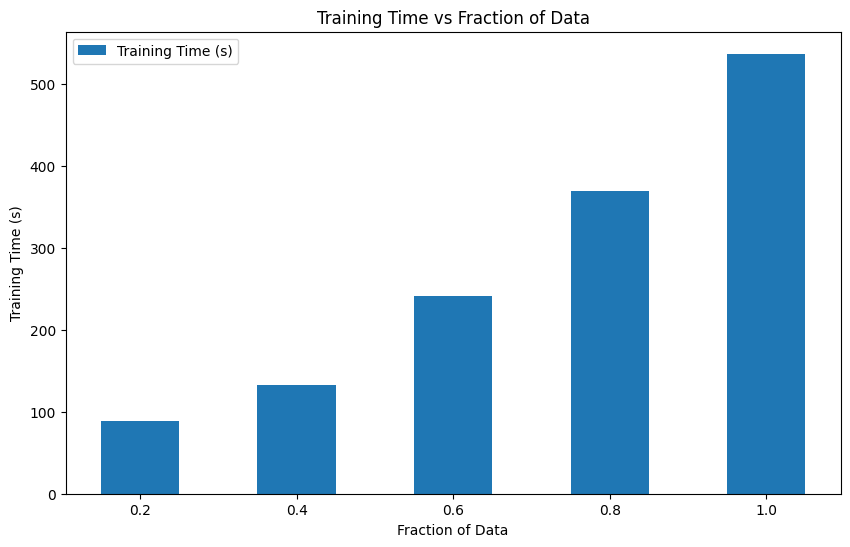

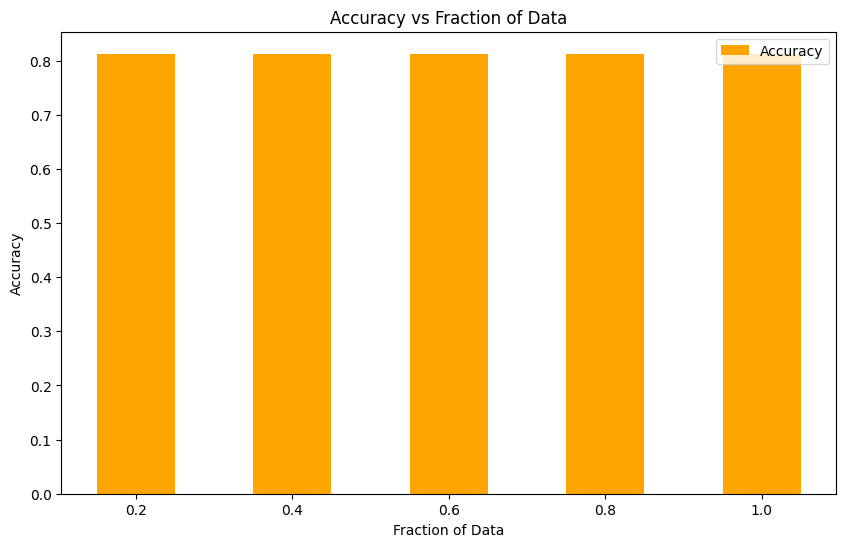

In [44]:
# Extracting fractions, training times, and accuracies from the results
fractions = [result[0] for result in spark_results]
training_times = [result[1] for result in spark_results]
accuracies = [result[2] for result in spark_results]

# Plotting Training Time
plt.figure(figsize=(10, 6))
plt.bar(fractions, training_times, width=0.1, label='Training Time (s)')
plt.xlabel('Fraction of Data')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Fraction of Data')
plt.xticks(fractions)
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 6))
plt.bar(fractions, accuracies, width=0.1, label='Accuracy', color='orange')
plt.xlabel('Fraction of Data')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Fraction of Data')
plt.xticks(fractions)
plt.legend()
plt.show()